In [1]:
import configparser
config = configparser.ConfigParser()
config.read('../config/config.ini')

['config/config.ini']

In [2]:
import sys
sys.path.insert(0, '../source/')
from preprocessing_images import PreprocessingImages

In [3]:
import pandas as pd
cols = ['Label', 'Latin Name', 'Common Name','Train Images', 'Validation Images']
label_df = pd.read_csv(f"../input/archive/monkey_labels.txt", names=cols, skiprows=1)
label_df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [4]:
train_generator, validation_generator = PreprocessingImages(config).preprocessImages()

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [5]:
from cnn_model import CNNModel
model = CNNModel(config, train_generator[0][0][0]).build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 74, 74, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2592)              0         
                                                                 
 dense (Dense)               (None, 150)               3

In [6]:
# Create the callbacks
from keras.callbacks import TensorBoard, EarlyStopping
callbacks = [
            TensorBoard(log_dir=config['CALLBACKS']['TENSORBOARD_LOGDIR'] + "3",
                        write_images=config['CALLBACKS']['TENSORBOARD_WRITEIMAGES'],
                        write_graph=config['CALLBACKS']['TENSORBOARD_WRITEGRAPH'],
                        update_freq=config['CALLBACKS']['TENSORBOARD_UPDATEFREQ']
                        ),
            EarlyStopping(monitor=config['CALLBACKS']['EARLYSTOPPING_MONITOR'],
                          mode=config['CALLBACKS']['EARLYSTOPPING_MODE'],
                          patience=int(config['CALLBACKS']['EARLYSTOPPING_PATIENCE']),
                          verbose=1)
]

In [7]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs = int(config['CNN_CONFIGURATION']['EPOCHS']),
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks,
    verbose = 1
)

<ipython-input-7-42bba9ec74c2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/200
17/17 [==============================] - 48s 2s/step - loss: 2.2951 - acc: 0.1518 - val_loss: 2.2217 - val_acc: 0.1680
Epoch 2/200
17/17 [==============================] - 39s 2s/step - loss: 2.1459 - acc: 0.2157 - val_loss: 2.0311 - val_acc: 0.2500
Epoch 3/200
17/17 [==============================] - 51s 3s/step - loss: 2.0291 - acc: 0.2640 - val_loss: 1.9767 - val_acc: 0.3008
Epoch 4/200
17/17 [==============================] - 42s 3s/step - loss: 1.8786 - acc: 0.3443 - val_loss: 1.8628 - val_acc: 0.3594
Epoch 5/200
17/17 [==============================] - 41s 3s/step - loss: 1.7466 - acc: 0.3772 - val_loss: 1.8142 - val_acc: 0.3242
Epoch 6/200
17/17 [==============================] - 41s 2s/step - loss: 1.7175 - acc: 0.4052 - val_loss: 1.5751 - val_acc: 0.4805
Epoch 7/200
17/17 [==============================] - 40s 2s/step - loss: 1.6158 - acc: 0.4294 - val_loss: 1.6549 - val_acc: 0.4414
Epoch 8/200
17/17 [==============================] - 40s 2s/step - loss: 1.6130 - a

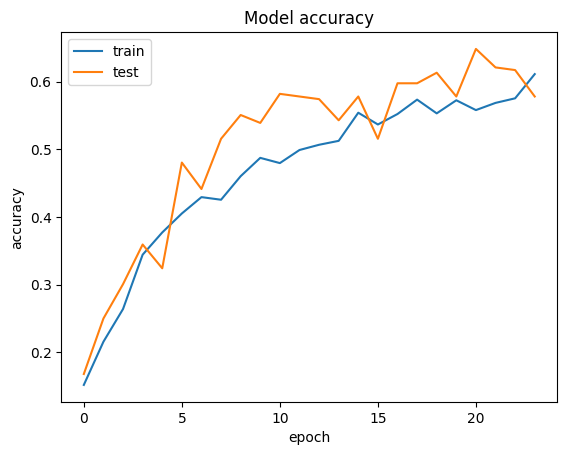

In [9]:
from aux_functions import pltResults
# Plot accuracy graph
pltResults(
    '../logs/',
    history.history['acc'],
    history.history['val_acc'],
    'Model accuracy',
    'epoch',
    'accuracy')

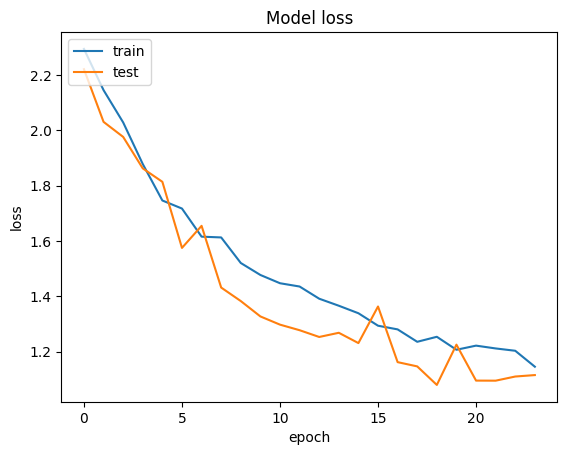

In [10]:
# Plot loss graph
pltResults(
    '../logs/',
    history.history['loss'],
    history.history['val_loss'],
    'Model loss',
    'epoch',
    'loss')